## Setup

In [22]:
# Add scripts directory to path
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent / 'scripts'))

# Import geometry functions
from geometry import (
    download_country_shapes,
    download_nuts3_shapes,
    join_shapes,
    point_in_shape,
    mask_shape,
    buffer_shape,
    get_shape_area,
    get_european_union_shape,
)

# For visualization
import matplotlib.pyplot as plt
import pandas as pd

print("✓ Setup complete")

✓ Setup complete


## 1. Download Country Shapes

Download boundaries for European countries. Data is cached locally after first download.

In [23]:
# Download Germany and Poland
countries = download_country_shapes(['DE', 'PL'])

print(f"Downloaded {len(countries)} countries")
print("\nCountry data:")
countries[['country', 'geometry']]

INFO:geometry:Loaded 2 country shapes


Downloaded 2 countries

Country data:


,country,geometry
68,DE,"MULTIPOLYGON (((10.45444 47.5558, 10.43954 47...."
176,PL,"MULTIPOLYGON (((18.32803 54.8346, 18.33793 54...."


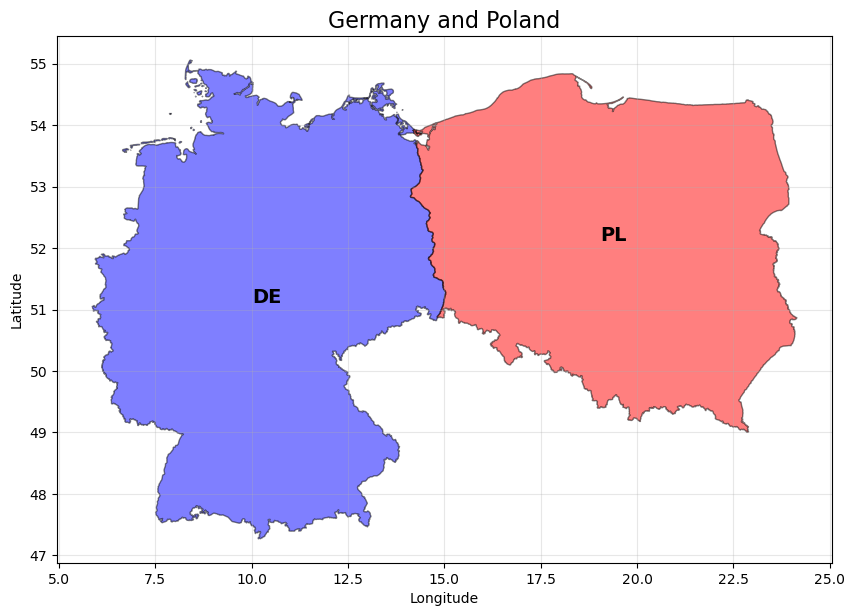

In [24]:
# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
countries.plot(ax=ax, edgecolor='black', color=['blue', 'red'], alpha=0.5)
countries.apply(lambda x: ax.annotate(text=x['country'], 
                                       xy=x.geometry.centroid.coords[0],
                                       ha='center', fontsize=14, fontweight='bold'), axis=1)
plt.title('Germany and Poland', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.show()

## 2. Join Shapes

Combine multiple geometries into a single unified boundary.

In [25]:
# Join Germany and Poland
combined = join_shapes(countries)

print(f"Combined shape type: {type(combined).__name__}")
print(f"Combined area: {get_shape_area(combined):,.0f} km²")

# Compare with individual areas
de_area = get_shape_area(countries[countries['country'] == 'DE'])
pl_area = get_shape_area(countries[countries['country'] == 'PL'])
print(f"\nGermany area:  {de_area:,.0f} km²")
print(f"Poland area:   {pl_area:,.0f} km²")
print(f"Sum of areas:  {de_area + pl_area:,.0f} km²")

INFO:geometry:Joined 2 shapes into unified boundary


Combined shape type: MultiPolygon
Combined area: 669,611 km²

Germany area:  357,670 km²
Poland area:   311,941 km²
Sum of areas:  669,611 km²


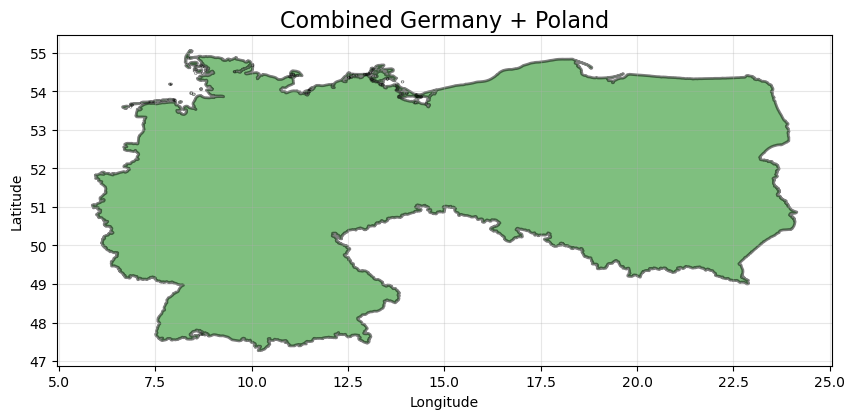

In [26]:
# Visualize combined shape
import geopandas as gpd

fig, ax = plt.subplots(figsize=(10, 8))
gpd.GeoDataFrame(geometry=[combined]).plot(ax=ax, color='green', alpha=0.5, edgecolor='black', linewidth=2)
plt.title('Combined Germany + Poland', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Point-in-Shape Checks

Test if coordinate points fall within boundaries.

In [27]:
# Define cities with coordinates (lat, lon)
cities = {
    'Berlin': (52.5200, 13.4050),
    'Munich': (48.1351, 11.5820),
    'Warsaw': (52.2297, 21.0122),
    'Krakow': (50.0647, 19.9450),
    'Paris': (48.8566, 2.3522),
    'Prague': (50.0755, 14.4378),
}

# Check which cities are in our combined region
results = []
for city, (lat, lon) in cities.items():
    in_combined = point_in_shape(lat, lon, combined)
    results.append({'City': city, 'Latitude': lat, 'Longitude': lon, 'In DE+PL': in_combined})

results_df = pd.DataFrame(results)
print("\nCity location checks:")
print(results_df.to_string(index=False))


City location checks:
  City  Latitude  Longitude  In DE+PL
Berlin   52.5200    13.4050      True
Munich   48.1351    11.5820      True
Warsaw   52.2297    21.0122      True
Krakow   50.0647    19.9450      True
 Paris   48.8566     2.3522     False
Prague   50.0755    14.4378     False


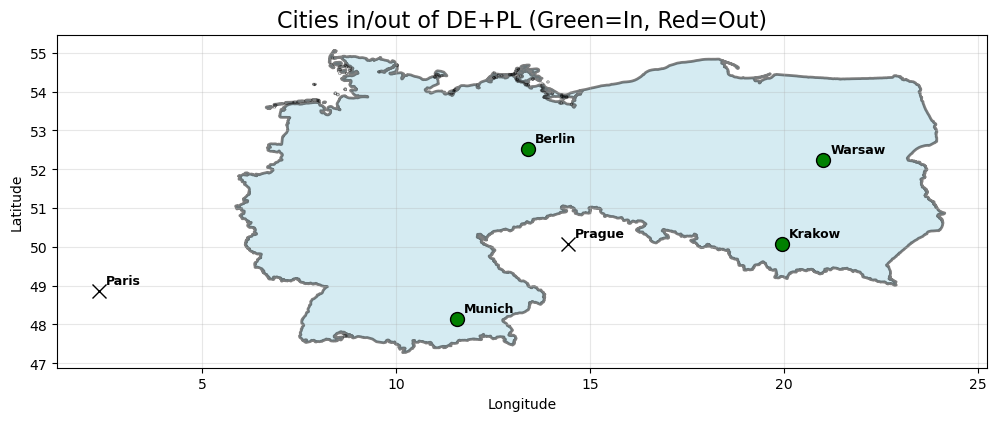

In [28]:
# Visualize cities on map
fig, ax = plt.subplots(figsize=(12, 10))

# Plot countries
gpd.GeoDataFrame(geometry=[combined]).plot(ax=ax, color='lightblue', alpha=0.5, edgecolor='black', linewidth=2)

# Plot cities
for city, (lat, lon) in cities.items():
    in_region = point_in_shape(lat, lon, combined)
    color = 'green' if in_region else 'red'
    marker = 'o' if in_region else 'x'
    ax.plot(lon, lat, marker=marker, color=color, markersize=10, markeredgecolor='black', markeredgewidth=1)
    ax.annotate(city, (lon, lat), xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

plt.title('Cities in/out of DE+PL (Green=In, Red=Out)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.show()

## 4. NUTS-3 Regions

Download and work with NUTS-3 statistical regions.

In [29]:
# Download NUTS-3 regions for Germany
nuts3_de = download_nuts3_shapes(['DE'])

print(f"Downloaded {len(nuts3_de)} NUTS-3 regions for Germany")
print("\nSample regions:")
nuts3_de[['NUTS_ID', 'NAME_LATN']].head(10)

INFO:geometry:Loaded 401 NUTS-3 region shapes


Downloaded 401 NUTS-3 regions for Germany

Sample regions:


,NUTS_ID,NAME_LATN
342,DE933,Harburg
343,DE934,Lüchow-Dannenberg
348,DE935,"Lüneburg, Landkreis"
349,DEA5A,Siegen-Wittgenstein
350,DEA5B,Soest
351,DE600,Hamburg
352,DE711,"Darmstadt, Kreisfreie Stadt"
353,DE712,"Frankfurt am Main, Kreisfreie Stadt"
354,DE713,"Offenbach am Main, Kreisfreie Stadt"
355,DE714,"Wiesbaden, Kreisfreie Stadt"


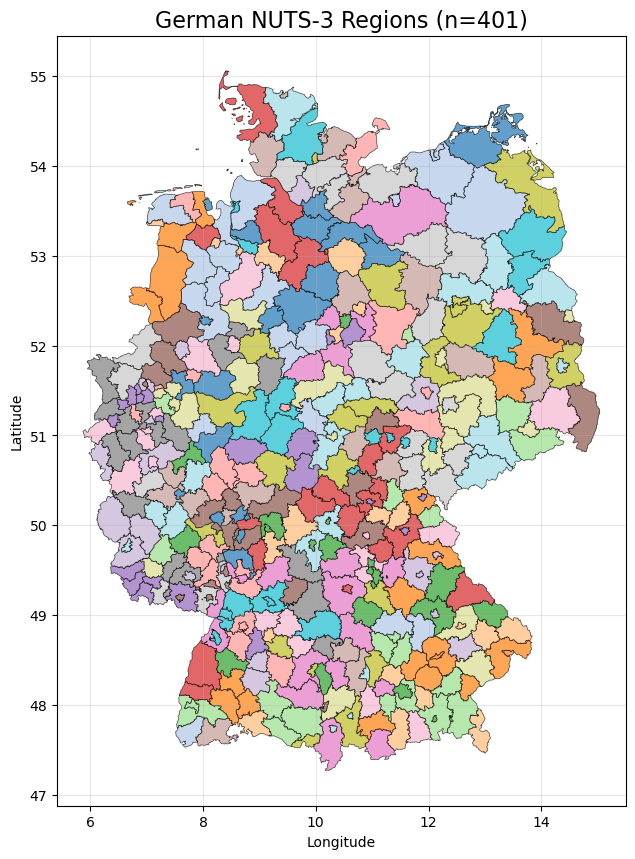

In [30]:
# Visualize NUTS-3 regions
fig, ax = plt.subplots(figsize=(12, 10))
nuts3_de.plot(ax=ax, edgecolor='black', linewidth=0.5, cmap='tab20', alpha=0.7)
plt.title(f'German NUTS-3 Regions (n={len(nuts3_de)})', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
# Find which NUTS-3 region contains Berlin
berlin = (52.5200, 13.4050)

for idx, row in nuts3_de.iterrows():
    if point_in_shape(berlin[0], berlin[1], row['geometry']):
        print(f"Berlin is in NUTS-3 region:")
        print(f"  ID: {row['NUTS_ID']}")
        print(f"  Name: {row['NAME_LATN']}")
        print(f"  Country: {row['CNTR_CODE']}")
        break

Berlin is in NUTS-3 region:
  ID: DE300
  Name: Berlin
  Country: DE


## 5. Intersection (Masking)

Compute the overlap between two boundaries.

In [32]:
# Create a circular region around Berlin
from shapely.geometry import Point

berlin_point = Point(13.4050, 52.5200)
berlin_circle = berlin_point.buffer(1.0)  # ~100km radius

# Find intersection with Germany
germany = countries[countries['country'] == 'DE']
intersection = mask_shape(germany, berlin_circle, return_gdf=True)

print(f"Intersection area: {get_shape_area(intersection):,.0f} km²")
print(f"Original Germany area: {get_shape_area(germany):,.0f} km²")

INFO:geometry:Computed intersection of boundaries


Intersection area: 23,409 km²
Original Germany area: 357,670 km²


/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_83847/1276148524.py:19: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='best')


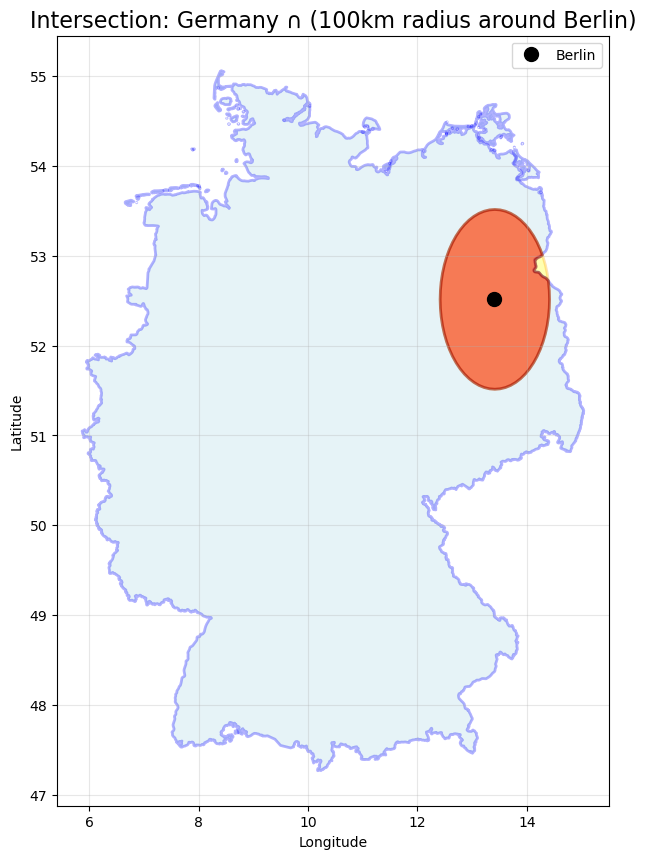

In [33]:
# Visualize intersection
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Germany
germany.plot(ax=ax, color='lightblue', alpha=0.3, edgecolor='blue', linewidth=2, label='Germany')

# Plot circle
gpd.GeoDataFrame(geometry=[berlin_circle]).plot(ax=ax, color='yellow', alpha=0.3, edgecolor='orange', linewidth=2, label='100km around Berlin')

# Plot intersection
intersection.plot(ax=ax, color='red', alpha=0.5, edgecolor='darkred', linewidth=2, label='Intersection')

# Plot Berlin
ax.plot(13.4050, 52.5200, 'ko', markersize=10, label='Berlin')

plt.title('Intersection: Germany ∩ (100km radius around Berlin)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Buffer Operations

Expand or contract boundaries by a distance.

In [34]:
# Download Luxembourg (small country)
luxembourg = download_country_shapes(['LU'])

# Create buffers
buffer_50km = buffer_shape(luxembourg, distance_km=50, return_gdf=True)
buffer_100km = buffer_shape(luxembourg, distance_km=100, return_gdf=True)

# Calculate areas
orig_area = get_shape_area(luxembourg)
area_50 = get_shape_area(buffer_50km)
area_100 = get_shape_area(buffer_100km)

print(f"Luxembourg area:        {orig_area:,.0f} km²")
print(f"+ 50km buffer:          {area_50:,.0f} km²  (+{area_50-orig_area:,.0f} km²)")
print(f"+ 100km buffer:         {area_100:,.0f} km²  (+{area_100-orig_area:,.0f} km²)")

INFO:geometry:Loaded 1 country shapes
INFO:geometry:Created 50km buffer around shape
INFO:geometry:Created 100km buffer around shape


Luxembourg area:        2,596 km²
+ 50km buffer:          22,053 km²  (+19,457 km²)
+ 100km buffer:         56,679 km²  (+54,083 km²)


/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_83847/3081237988.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='best')
/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_83847/3081237988.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


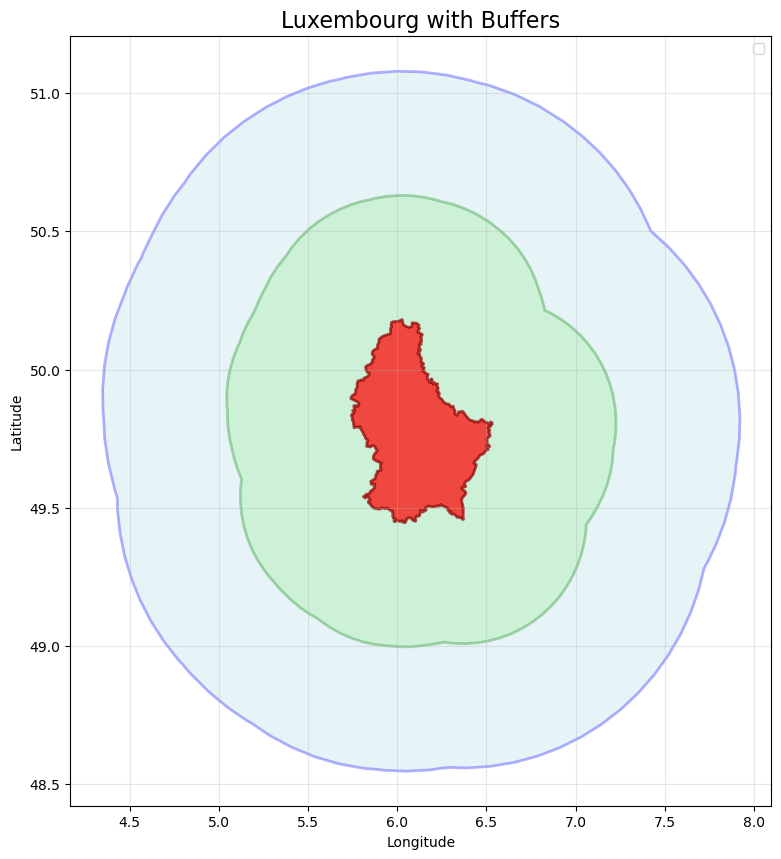

In [35]:
# Visualize buffers
fig, ax = plt.subplots(figsize=(10, 10))

buffer_100km.plot(ax=ax, color='lightblue', alpha=0.3, edgecolor='blue', linewidth=2, label='100km buffer')
buffer_50km.plot(ax=ax, color='lightgreen', alpha=0.3, edgecolor='green', linewidth=2, label='50km buffer')
luxembourg.plot(ax=ax, color='red', alpha=0.7, edgecolor='darkred', linewidth=2, label='Luxembourg')

plt.title('Luxembourg with Buffers', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

## 7. European Union Boundary

Get the unified boundary of all EU member states.

In [36]:
# Get EU boundary
eu = get_european_union_shape()

print(f"EU shape type: {type(eu).__name__}")
print(f"EU total area: {get_shape_area(eu):,.0f} km²")

INFO:geometry:Loaded 26 country shapes
INFO:geometry:Joined 26 shapes into unified boundary


EU shape type: MultiPolygon
EU total area: 4,092,874 km²


In [37]:
# Check capital cities
capitals = {
    'Brussels (Belgium)': (50.8503, 4.3517),
    'Berlin (Germany)': (52.5200, 13.4050),
    'Paris (France)': (48.8566, 2.3522),
    'London (UK - not EU)': (51.5074, -0.1278),
    'Oslo (Norway - not EU)': (59.9139, 10.7522),
}

print("\nCapital cities in EU:")
for city, (lat, lon) in capitals.items():
    is_in_eu = point_in_shape(lat, lon, eu)
    status = "✓ In EU" if is_in_eu else "✗ Not in EU"
    print(f"  {city:30s}: {status}")


Capital cities in EU:
  Brussels (Belgium)            : ✓ In EU
  Berlin (Germany)              : ✓ In EU
  Paris (France)                : ✓ In EU
  London (UK - not EU)          : ✗ Not in EU
  Oslo (Norway - not EU)        : ✗ Not in EU


## 8. Practical Application: Filter Power Network Buses

Use the geometry module to filter buses by country.

In [38]:
# Load buses data
buses_path = Path.cwd().parent / 'data' / 'raw' / 'OSM Prebuilt Electricity Network' / 'buses.csv'

if buses_path.exists():
    buses = pd.read_csv(buses_path)
    print(f"Loaded {len(buses)} buses")
    print("\nSample data:")
    print(buses[['bus_id', 'voltage', 'x', 'y', 'country']].head())
else:
    print(f"Buses file not found at {buses_path}")
    buses = None

Loaded 6737 buses

Sample data:
     bus_id  voltage          x          y country
0   AL1-220      220  20.111702  42.096798      AL
1  AL10-220      220  19.522149  40.478444      AL
2   AL2-220      220  20.031168  42.069050      AL
3   AL3-400      400  19.652495  42.010831      AL
4   AL4-220      220  19.972850  41.584771      AL


In [39]:
if buses is not None:
    # Filter buses in Germany using geometry
    germany_shape = download_country_shapes(['DE'])
    
    # Check first 100 buses (for speed)
    sample_buses = buses.head(100)
    
    sample_buses['in_germany_geom'] = sample_buses.apply(
        lambda row: point_in_shape(row['y'], row['x'], germany_shape),
        axis=1
    )
    
    # Compare with country column
    sample_buses['in_germany_col'] = sample_buses['country'] == 'DE'
    
    # Check agreement
    agreement = (sample_buses['in_germany_geom'] == sample_buses['in_germany_col']).sum()
    print(f"\nGeometry vs column agreement: {agreement}/{len(sample_buses)} ({100*agreement/len(sample_buses):.1f}%)")
    
    print(f"\nBuses in Germany (by geometry): {sample_buses['in_germany_geom'].sum()}")
    print(f"Buses in Germany (by column):   {sample_buses['in_germany_col'].sum()}")

INFO:geometry:Loaded 1 country shapes



Geometry vs column agreement: 100/100 (100.0%)

Buses in Germany (by geometry): 0
Buses in Germany (by column):   0


/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_83847/773347883.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_buses['in_germany_geom'] = sample_buses.apply(
/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_83847/773347883.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_buses['in_germany_col'] = sample_buses['country'] == 'DE'


## Summary

This notebook demonstrated:

1. ✅ **Downloading shapes** - Countries and NUTS-3 regions from Eurostat GISCO
2. ✅ **Joining shapes** - Union multiple geometries into one
3. ✅ **Point checks** - Test if coordinates fall within boundaries
4. ✅ **NUTS-3 regions** - Compatible with all geometry operations
5. ✅ **Intersection** - Compute overlap between boundaries
6. ✅ **Buffers** - Expand/contract boundaries by distance
7. ✅ **EU boundary** - Unified shape of all EU member states
8. ✅ **Practical use** - Filter power network elements by location

All data is automatically cached for fast subsequent access!

## 9. Europe-wide Visualization

Visualize the entire European power network infrastructure with countries, Voronoi regions, and bus locations.

In [40]:
import json
import geopandas as gpd

# Define cache paths
cache_dir = Path.cwd().parent / 'data' / 'cache' / 'geometry'

# Load all countries
all_countries_path = cache_dir / 'all_countries.geojson'
voronoi_eu27_path = cache_dir / 'voronoi_eu27.geojson'

if all_countries_path.exists() and voronoi_eu27_path.exists():
    # Load geometries
    with open(all_countries_path) as f:
        all_countries_geojson = json.load(f)
    all_countries_gdf = gpd.GeoDataFrame.from_features(all_countries_geojson['features'])
    
    with open(voronoi_eu27_path) as f:
        voronoi_geojson = json.load(f)
    voronoi_gdf = gpd.GeoDataFrame.from_features(voronoi_geojson['features'])
    
    # Load buses
    buses_path = Path.cwd().parent / 'data' / 'raw' / 'OSM Prebuilt Electricity Network' / 'buses.csv'
    if buses_path.exists():
        buses_data = pd.read_csv(buses_path)
        print(f"✓ Loaded {len(all_countries_gdf)} countries")
        print(f"✓ Loaded {len(voronoi_gdf)} Voronoi cells")
        print(f"✓ Loaded {len(buses_data)} buses")
    else:
        buses_data = None
        print(f"⚠ Buses file not found")
else:
    print(f"⚠ Cache files not found")
    print(f"  Expected: {all_countries_path}")
    print(f"  Expected: {voronoi_eu27_path}")
    buses_data = None


✓ Loaded 36 countries
✓ Loaded 5249 Voronoi cells
✓ Loaded 6737 buses


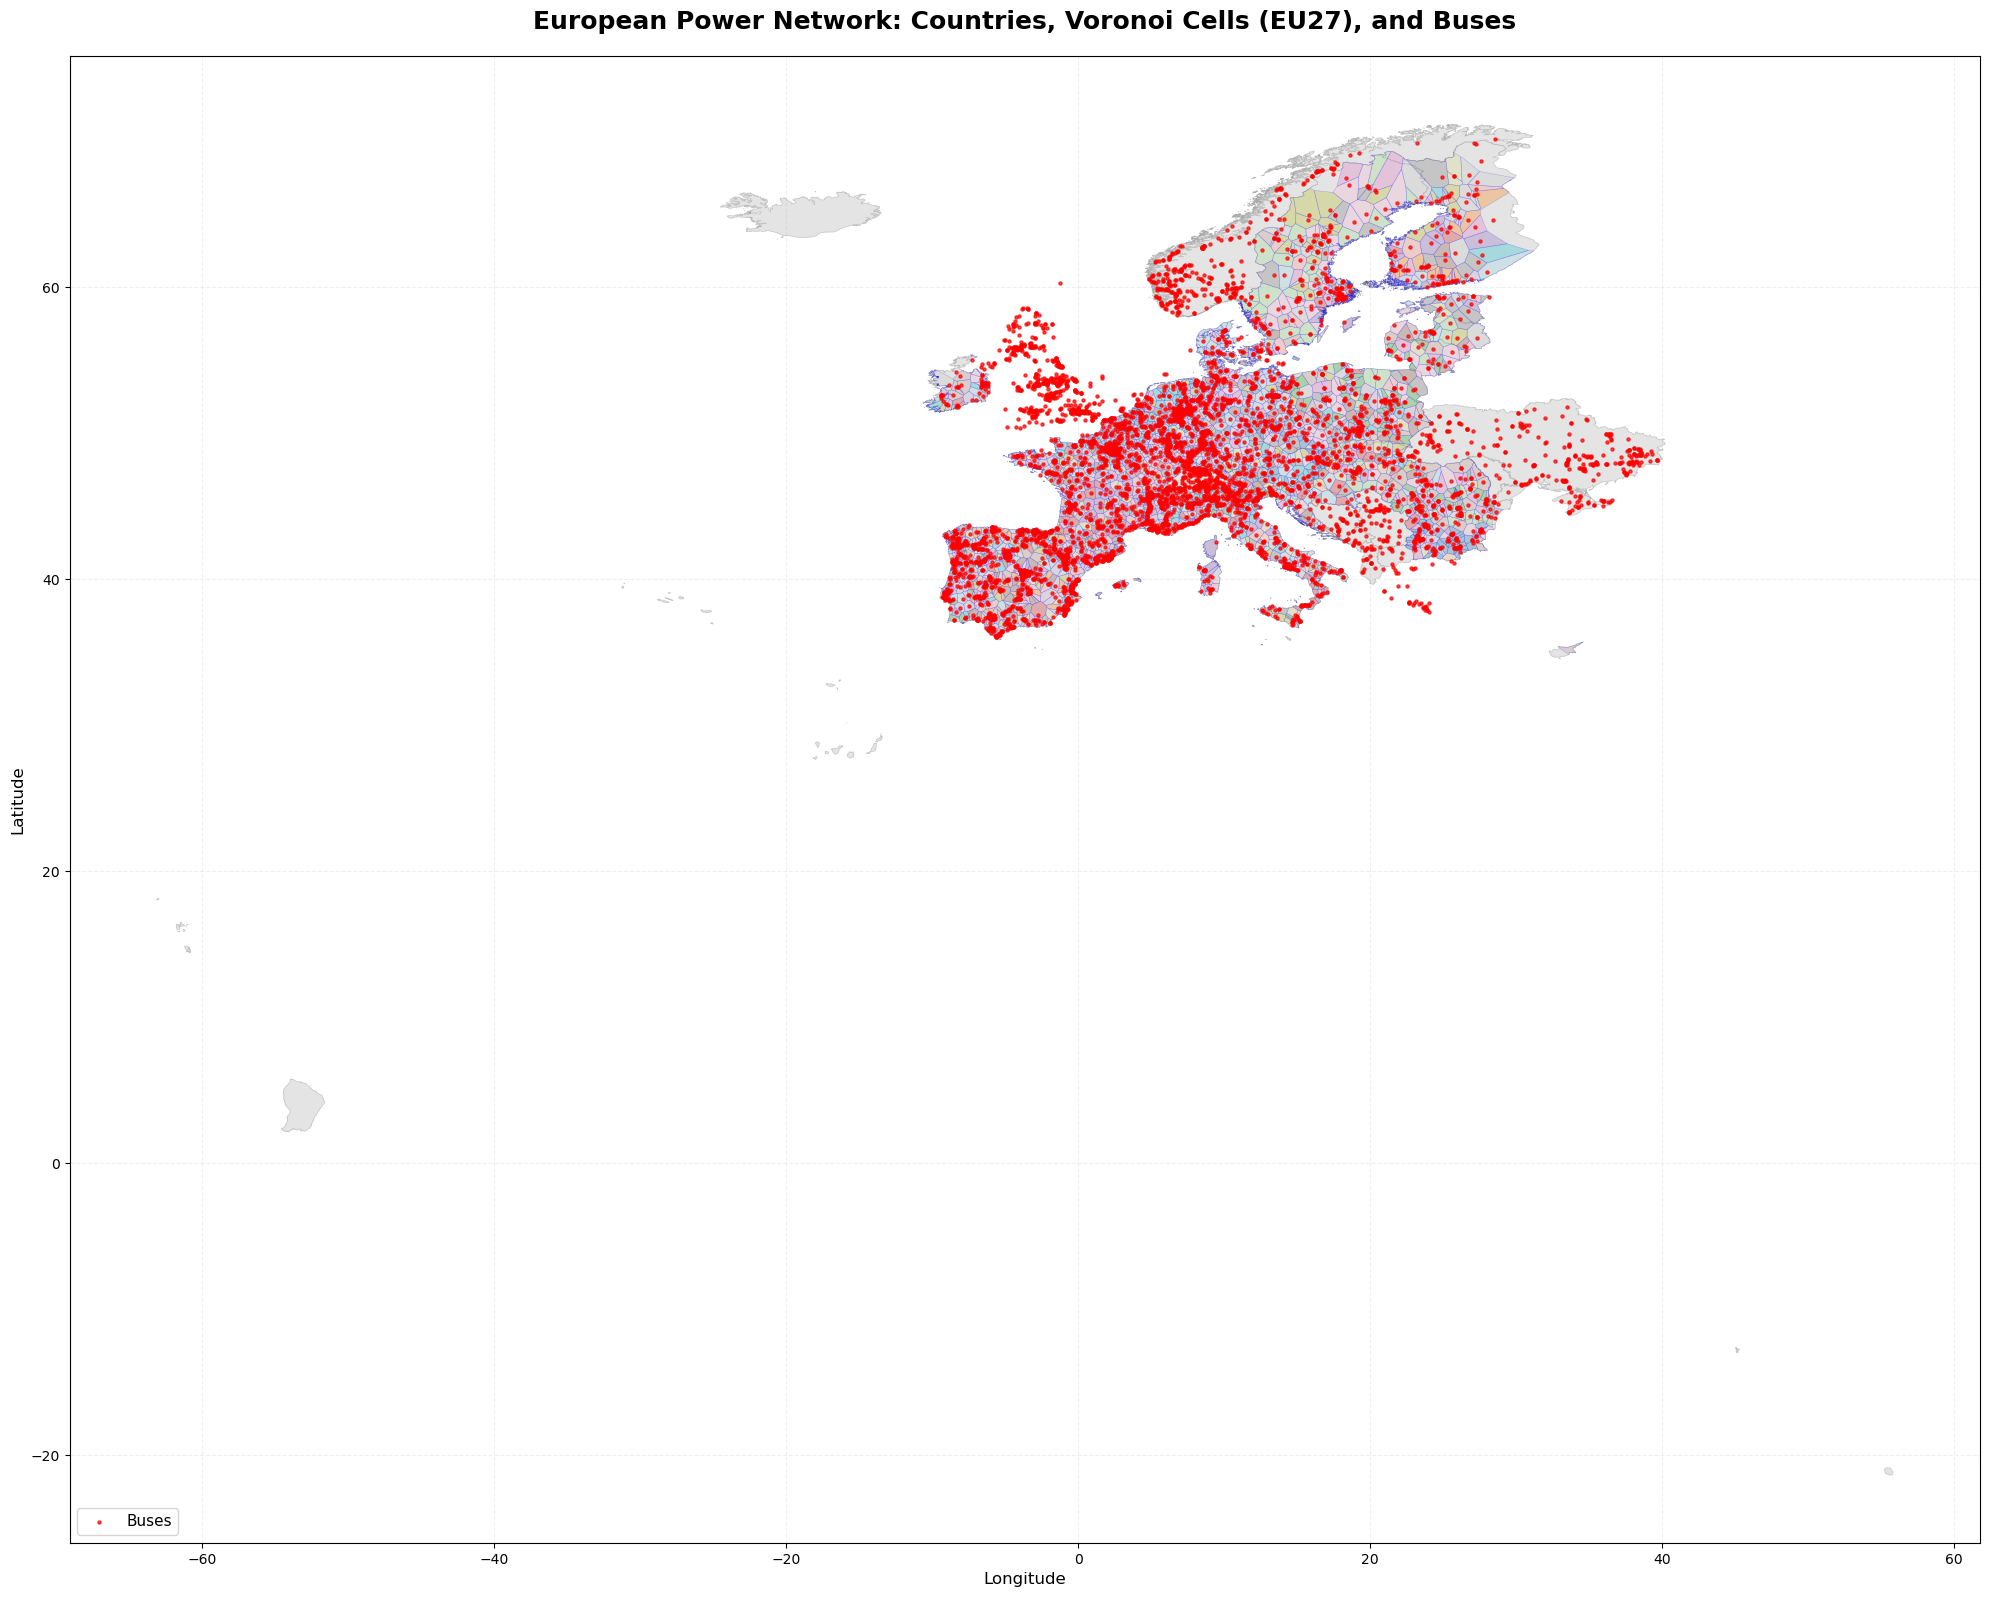


✓ Visualization complete:
  • Gray regions: All European countries
  • Colored polygons: Voronoi cells for EU27 buses
  • Red dots: Power network buses (6737 total)


In [ ]:
if buses_data is not None:
    
    # Create figure with larger size for detailed Europe view
    fig, ax = plt.subplots(figsize=(20, 16))
    
    # Plot all countries with subtle color
    all_countries_gdf.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth=0.5, alpha=0.6)
    
    # Plot Voronoi cells with colors
    voronoi_gdf.plot(ax=ax, alpha=0.3, edgecolor='blue', linewidth=0.3, cmap='tab20')
    
    # Plot buses as small dots
    ax.scatter(buses_data['x'], buses_data['y'], c='red', s=5, alpha=0.7, label='Buses', zorder=5)
    
    # Formatting
    ax.set_title('European Power Network: Countries, Voronoi Cells (EU27), and Buses', fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_xlim(-5,40)
    ax.set_ylim(30,50)
    ax.legend(['Buses'], loc='lower left', fontsize=11)
    ax.grid(True, alpha=0.2, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Visualization complete:")
    print(f"  • Gray regions: All European countries")
    print(f"  • Colored polygons: Voronoi cells for EU27 buses")
    print(f"  • Red dots: Power network buses ({len(buses_data)} total)")
else:
    print("Cannot create visualization - missing data files")


In [21]:
if buses_data is not None:
    # Statistics
    print("\n📊 Network Statistics:")
    print(f"  Total buses: {len(buses_data)}")
    print(f"  Voltage levels: {sorted(buses_data['voltage'].unique())}")
    print(f"  Countries represented: {buses_data['country'].nunique()}")
    print(f"\nBuses by country (top 10):")
    print(buses_data['country'].value_counts().head(10))
    
    # Voronoi statistics
    print(f"\n  Voronoi EU27 cells: {len(voronoi_gdf)}")
    
    # Bounding box info
    print(f"\n🌍 Geographic extent:")
    print(f"  Longitude range: [{buses_data['x'].min():.2f}, {buses_data['x'].max():.2f}]")
    print(f"  Latitude range: [{buses_data['y'].min():.2f}, {buses_data['y'].max():.2f}]")



📊 Network Statistics:
  Total buses: 6737
  Voltage levels: [np.int64(150), np.int64(200), np.int64(220), np.int64(225), np.int64(236), np.int64(250), np.int64(270), np.int64(275), np.int64(300), np.int64(320), np.int64(330), np.int64(350), np.int64(380), np.int64(400), np.int64(420), np.int64(450), np.int64(500), np.int64(515), np.int64(525), np.int64(600), np.int64(750)]
  Countries represented: 36

Buses by country (top 10):
country
FR    1215
ES    1047
DE     795
IT     592
GB     501
NO     295
UA     294
PL     225
SE     215
CH     193
Name: count, dtype: int64

  Voronoi EU27 cells: 5249

🌍 Geographic extent:
  Longitude range: [-9.42, 39.67]
  Latitude range: [36.03, 70.17]
